## Note
#### This notebook uses the same network and Loss Function as HEMIGEN: Human Embryo Image Generator Based on Generative Adversarial Networks Paper

## Importing Necessary Libraries

In [1]:
import os
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

## Necessary Variables and Hyperparameters 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = "/app/Datasets/T2toT8-gan/t1"
files = ['{}/{}'.format(root, x) for x in os.listdir(root)]
batch_size = 128
image_size = 64
nc = 1 # number of image channels
nz = 100 # latent vector size
epochs = 500
lr = 0.0002
beta1 = 0.7

## Custum Dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, files, transform):
        super().__init__()
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("L")
        image = self.transform(image)
        return image, torch.Tensor([0])

## Creating and Loading Dataset

In [4]:
dataset = MyDataset(files=files,
                    transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5), (0.5)),
                       ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

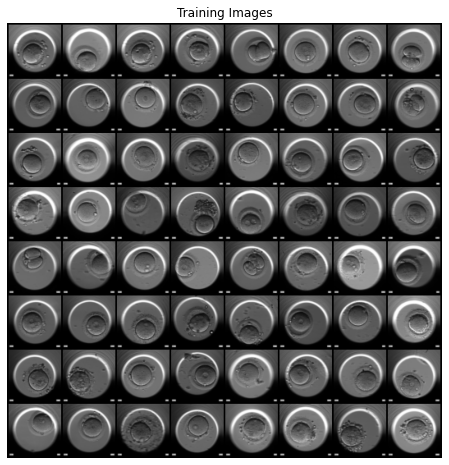

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], 
                                         padding=2, 
                                         normalize=True).cpu(),(1,2,0)));

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator For Generating Fake Images From Latent Vector

In [7]:
class Generator(nn.Module):
    def __init__(self, nz, image_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features=256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features=512, momentum=0.8),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features=1024, momentum=0.8),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()
        )
        self.image_size = image_size
        
    def forward(self, input):
        output = self.main(input)
        return output.view(output.shape[0], nc, self.image_size, self.image_size)


In [8]:
# Create the generator
gen = Generator(nz, image_size).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
gen.apply(weights_init);

### Discriminator For Classifying Fake And Real Images

In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nc * img_size * img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input.view(input.shape[0], -1)).view(-1)

In [10]:
# Create the Discriminator
disc = Discriminator(image_size).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
disc.apply(weights_init);

## Loss Function and Optimizer

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

## Training Step

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        opt_disc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        opt_gen.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/276]	Loss_D: 1.3825	Loss_G: 0.7173	D(x): 0.4968	D(G(z)): 0.4948 / 0.4881
[0/100][50/276]	Loss_D: 0.3930	Loss_G: 1.5619	D(x): 0.9853	D(G(z)): 0.2969 / 0.2651
[0/100][100/276]	Loss_D: 0.3352	Loss_G: 2.2008	D(x): 0.9691	D(G(z)): 0.2376 / 0.1391
[0/100][150/276]	Loss_D: 0.3347	Loss_G: 3.4786	D(x): 0.9853	D(G(z)): 0.2145 / 0.1141
[0/100][200/276]	Loss_D: 0.2547	Loss_G: 4.4309	D(x): 0.9854	D(G(z)): 0.1673 / 0.0475
[0/100][250/276]	Loss_D: 0.1703	Loss_G: 6.3130	D(x): 0.9478	D(G(z)): 0.0883 / 0.0243
[1/100][0/276]	Loss_D: 0.2084	Loss_G: 7.1277	D(x): 0.9696	D(G(z)): 0.1290 / 0.0079
[1/100][50/276]	Loss_D: 0.1197	Loss_G: 8.2389	D(x): 0.9584	D(G(z)): 0.0626 / 0.0028
[1/100][100/276]	Loss_D: 0.3463	Loss_G: 9.0053	D(x): 0.9667	D(G(z)): 0.1801 / 0.0012
[1/100][150/276]	Loss_D: 0.4928	Loss_G: 7.8066	D(x): 0.8690	D(G(z)): 0.1880 / 0.0114
[1/100][200/276]	Loss_D: 0.3718	Loss_G: 9.3816	D(x): 0.8626	D(G(z)): 0.1565 / 0.0008
[1/100][250/276]	Loss_D: 0.2530	Loss_G: 7.412

[16/100][50/276]	Loss_D: 1.5722	Loss_G: 1.1344	D(x): 0.4672	D(G(z)): 0.5112 / 0.3779
[16/100][100/276]	Loss_D: 1.6272	Loss_G: 1.4259	D(x): 0.4939	D(G(z)): 0.5498 / 0.3455
[16/100][150/276]	Loss_D: 1.6598	Loss_G: 1.4434	D(x): 0.5650	D(G(z)): 0.5798 / 0.4220
[16/100][200/276]	Loss_D: 1.4831	Loss_G: 1.8930	D(x): 0.4262	D(G(z)): 0.4052 / 0.2833
[16/100][250/276]	Loss_D: 1.4938	Loss_G: 2.0456	D(x): 0.5102	D(G(z)): 0.5044 / 0.2707
[17/100][0/276]	Loss_D: 1.7657	Loss_G: 1.2846	D(x): 0.4711	D(G(z)): 0.5885 / 0.3641
[17/100][50/276]	Loss_D: 1.5592	Loss_G: 1.8303	D(x): 0.4203	D(G(z)): 0.4410 / 0.2402
[17/100][100/276]	Loss_D: 1.4494	Loss_G: 1.0807	D(x): 0.5968	D(G(z)): 0.5743 / 0.3800
[17/100][150/276]	Loss_D: 1.3229	Loss_G: 1.1794	D(x): 0.5716	D(G(z)): 0.5082 / 0.3501
[17/100][200/276]	Loss_D: 1.3049	Loss_G: 1.1443	D(x): 0.5331	D(G(z)): 0.4717 / 0.3652
[17/100][250/276]	Loss_D: 1.3206	Loss_G: 1.5164	D(x): 0.5336	D(G(z)): 0.4680 / 0.3077
[18/100][0/276]	Loss_D: 1.5129	Loss_G: 1.0902	D(x): 0.5226

[32/100][50/276]	Loss_D: 1.4602	Loss_G: 0.9619	D(x): 0.4826	D(G(z)): 0.5002 / 0.4026
[32/100][100/276]	Loss_D: 1.7109	Loss_G: 0.7897	D(x): 0.4842	D(G(z)): 0.6028 / 0.4834
[32/100][150/276]	Loss_D: 1.6384	Loss_G: 0.7557	D(x): 0.4563	D(G(z)): 0.5632 / 0.4777
[32/100][200/276]	Loss_D: 1.4597	Loss_G: 0.8478	D(x): 0.4958	D(G(z)): 0.5208 / 0.4351
[32/100][250/276]	Loss_D: 1.6405	Loss_G: 0.9352	D(x): 0.4584	D(G(z)): 0.5681 / 0.3969
[33/100][0/276]	Loss_D: 1.5916	Loss_G: 0.9005	D(x): 0.4711	D(G(z)): 0.5494 / 0.4301
[33/100][50/276]	Loss_D: 1.7084	Loss_G: 0.6988	D(x): 0.4565	D(G(z)): 0.5856 / 0.5182
[33/100][100/276]	Loss_D: 1.4529	Loss_G: 0.8563	D(x): 0.5051	D(G(z)): 0.5183 / 0.4551
[33/100][150/276]	Loss_D: 1.6971	Loss_G: 0.7322	D(x): 0.4523	D(G(z)): 0.5763 / 0.5005
[33/100][200/276]	Loss_D: 1.6835	Loss_G: 0.6494	D(x): 0.5090	D(G(z)): 0.6173 / 0.5391
[33/100][250/276]	Loss_D: 1.6283	Loss_G: 0.7529	D(x): 0.4382	D(G(z)): 0.5401 / 0.4854
[34/100][0/276]	Loss_D: 1.5210	Loss_G: 0.7424	D(x): 0.5038

[48/100][50/276]	Loss_D: 1.4008	Loss_G: 0.8188	D(x): 0.4778	D(G(z)): 0.4811 / 0.4444
[48/100][100/276]	Loss_D: 1.3571	Loss_G: 0.8254	D(x): 0.4816	D(G(z)): 0.4616 / 0.4427
[48/100][150/276]	Loss_D: 1.4852	Loss_G: 0.6983	D(x): 0.4850	D(G(z)): 0.5284 / 0.5022
[48/100][200/276]	Loss_D: 1.5118	Loss_G: 0.7886	D(x): 0.4496	D(G(z)): 0.4981 / 0.4644
[48/100][250/276]	Loss_D: 1.5799	Loss_G: 0.7742	D(x): 0.4632	D(G(z)): 0.5467 / 0.4690
[49/100][0/276]	Loss_D: 1.3872	Loss_G: 0.7504	D(x): 0.5178	D(G(z)): 0.5053 / 0.4778
[49/100][50/276]	Loss_D: 1.4884	Loss_G: 0.8374	D(x): 0.4713	D(G(z)): 0.5165 / 0.4367
[49/100][100/276]	Loss_D: 1.3898	Loss_G: 0.7394	D(x): 0.5366	D(G(z)): 0.5304 / 0.4800
[49/100][150/276]	Loss_D: 1.4446	Loss_G: 0.7648	D(x): 0.5100	D(G(z)): 0.5289 / 0.4681
[49/100][200/276]	Loss_D: 1.3281	Loss_G: 0.9421	D(x): 0.5129	D(G(z)): 0.4674 / 0.4022
[49/100][250/276]	Loss_D: 1.5294	Loss_G: 0.8351	D(x): 0.4424	D(G(z)): 0.5021 / 0.4440
[50/100][0/276]	Loss_D: 1.4970	Loss_G: 0.6905	D(x): 0.5159

[64/100][50/276]	Loss_D: 1.6476	Loss_G: 1.0312	D(x): 0.3512	D(G(z)): 0.4280 / 0.3735
[64/100][100/276]	Loss_D: 1.5024	Loss_G: 0.7106	D(x): 0.5030	D(G(z)): 0.5434 / 0.5011
[64/100][150/276]	Loss_D: 1.5618	Loss_G: 0.7794	D(x): 0.4400	D(G(z)): 0.5141 / 0.4685
[64/100][200/276]	Loss_D: 1.6416	Loss_G: 0.8831	D(x): 0.4447	D(G(z)): 0.5189 / 0.4246
[64/100][250/276]	Loss_D: 1.4702	Loss_G: 0.7939	D(x): 0.4770	D(G(z)): 0.5138 / 0.4556
[65/100][0/276]	Loss_D: 1.4854	Loss_G: 0.7183	D(x): 0.5056	D(G(z)): 0.5458 / 0.4918
[65/100][50/276]	Loss_D: 1.5693	Loss_G: 0.8162	D(x): 0.4848	D(G(z)): 0.5511 / 0.4531
[65/100][100/276]	Loss_D: 1.4902	Loss_G: 0.7240	D(x): 0.5237	D(G(z)): 0.5585 / 0.4941
[65/100][150/276]	Loss_D: 1.3853	Loss_G: 0.9409	D(x): 0.4529	D(G(z)): 0.4382 / 0.4027
[65/100][200/276]	Loss_D: 1.3739	Loss_G: 0.8819	D(x): 0.4831	D(G(z)): 0.4700 / 0.4188
[65/100][250/276]	Loss_D: 1.5248	Loss_G: 0.7184	D(x): 0.5356	D(G(z)): 0.5756 / 0.4947
[66/100][0/276]	Loss_D: 1.4750	Loss_G: 0.8314	D(x): 0.4620

[80/100][50/276]	Loss_D: 1.4565	Loss_G: 0.7513	D(x): 0.4972	D(G(z)): 0.5281 / 0.4741
[80/100][100/276]	Loss_D: 1.6630	Loss_G: 0.7041	D(x): 0.4504	D(G(z)): 0.5656 / 0.5101
[80/100][150/276]	Loss_D: 1.3907	Loss_G: 0.7381	D(x): 0.5218	D(G(z)): 0.5178 / 0.4822
[80/100][200/276]	Loss_D: 1.4254	Loss_G: 0.8884	D(x): 0.4824	D(G(z)): 0.4860 / 0.4289
[80/100][250/276]	Loss_D: 1.5259	Loss_G: 0.8265	D(x): 0.4514	D(G(z)): 0.5080 / 0.4448
[81/100][0/276]	Loss_D: 1.4480	Loss_G: 0.7572	D(x): 0.5036	D(G(z)): 0.5302 / 0.4712
[81/100][50/276]	Loss_D: 1.4981	Loss_G: 0.7949	D(x): 0.4844	D(G(z)): 0.5334 / 0.4619
[81/100][100/276]	Loss_D: 1.5336	Loss_G: 0.7288	D(x): 0.4674	D(G(z)): 0.5288 / 0.4932
[81/100][150/276]	Loss_D: 1.4039	Loss_G: 0.9641	D(x): 0.4745	D(G(z)): 0.4752 / 0.3839
[81/100][200/276]	Loss_D: 1.4056	Loss_G: 0.8033	D(x): 0.5089	D(G(z)): 0.5096 / 0.4521
[81/100][250/276]	Loss_D: 1.6076	Loss_G: 0.7137	D(x): 0.4979	D(G(z)): 0.5758 / 0.4941
[82/100][0/276]	Loss_D: 1.5386	Loss_G: 0.7863	D(x): 0.4313

[96/100][50/276]	Loss_D: 1.5267	Loss_G: 0.6741	D(x): 0.4991	D(G(z)): 0.5601 / 0.5120
[96/100][100/276]	Loss_D: 1.4039	Loss_G: 0.7683	D(x): 0.4814	D(G(z)): 0.4855 / 0.4672
[96/100][150/276]	Loss_D: 1.4300	Loss_G: 0.8098	D(x): 0.4730	D(G(z)): 0.4835 / 0.4546
[96/100][200/276]	Loss_D: 1.4134	Loss_G: 0.8334	D(x): 0.4931	D(G(z)): 0.4994 / 0.4420
[96/100][250/276]	Loss_D: 1.5321	Loss_G: 0.8202	D(x): 0.4231	D(G(z)): 0.4788 / 0.4433
[97/100][0/276]	Loss_D: 1.4431	Loss_G: 0.7419	D(x): 0.5096	D(G(z)): 0.5297 / 0.4809
[97/100][50/276]	Loss_D: 1.4164	Loss_G: 0.7767	D(x): 0.5188	D(G(z)): 0.5217 / 0.4635
[97/100][100/276]	Loss_D: 1.4257	Loss_G: 0.7556	D(x): 0.5301	D(G(z)): 0.5398 / 0.4726
[97/100][150/276]	Loss_D: 1.3567	Loss_G: 0.8579	D(x): 0.5091	D(G(z)): 0.4911 / 0.4253
[97/100][200/276]	Loss_D: 1.5435	Loss_G: 0.6702	D(x): 0.5068	D(G(z)): 0.5721 / 0.5174
[97/100][250/276]	Loss_D: 1.3640	Loss_G: 0.8354	D(x): 0.5026	D(G(z)): 0.4781 / 0.4410
[98/100][0/276]	Loss_D: 1.3638	Loss_G: 0.7944	D(x): 0.5030

## Discrimator And Generator Loss Curve

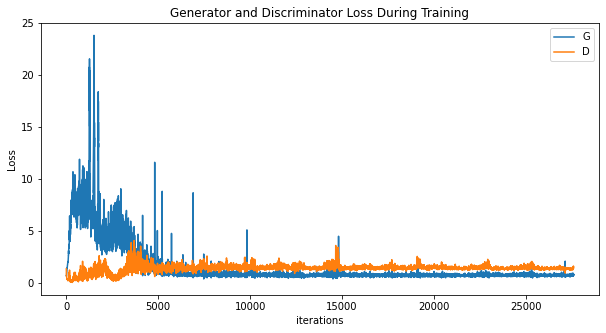

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Output From Generator Post Training

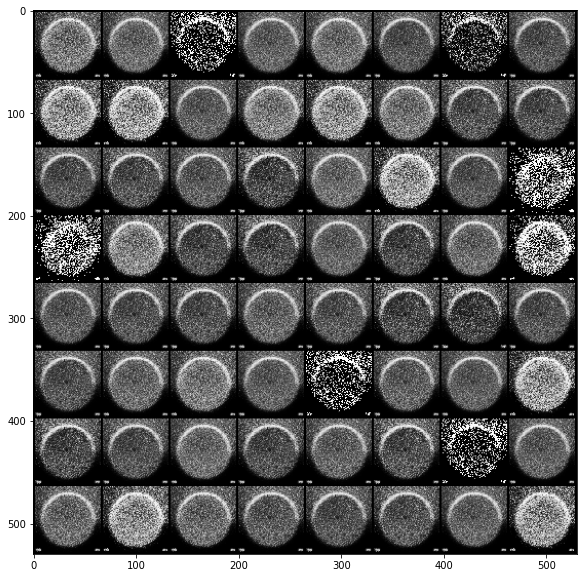

In [15]:
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)));